L'obiettivo di questa esercitazione è quello di arrivare ad implementare un sistema completo di classificazione dei sopravvissuti al disastro del Titanic. Per farlo, partiremo dall'omonimo dataset, faremo un'analisi completa dello stesso, e cercheremo di raggiungere il miglior risultato possibile in termini di accuracy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

## Parte 1: estrazione dei dati

Finora, abbiamo sempre usato la funzione `read_csv` di Pandas per la lettura di un dataset. Scikit Learn, però, offre la funzione [`fetch_openml`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html), che permette di estrarre un dataframe da [OpenML](https://www.openml.org/), nota repository online dalla quale è possibile reperire numerosi dataset.

Proviamo quindi ad estrarre i dati usando proprio questa funzione.

> **Suggerimento**: la funzione `fetch_openml` restituisce un oggetto. Esploriamolo, assieme alla documentazione, per estrarre il dataframe.

In [2]:
data = fetch_openml("titanic", version=1, as_frame=True)
df = data.frame

## Parte 2: Exploratory data analysis

Come abbiamo visto, è sempre opportuno "esplorare" i dati a nostra disposizione.

### Parte 2.1: Tipologia di feature e preprocessing

Per prima cosa, quindi, osserviamoli, guardando i primi cinque campioni, e valutiamo il tipo delle feature che stiamo utilizzando.

In [3]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
df.dtypes

pclass        float64
survived     category
name           object
sex          category
age           float64
sibsp         float64
parch         float64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

Notiamo subito che ci sono dei `NaN` e dei `None` relativi a diverse feature.

> **Suggerimento**: `NaN` e `None` *non* sono analoghi. Entrambi indicano la mancanza di dati, ma `None` implica la presenza di un oggetto, mentre `NaN` quella di un valore numerico. In tal senso, a [questo indirizzo](https://stackoverflow.com/questions/17534106/what-is-the-difference-between-nan-and-none) potete trovare un'interessante disquisizione.

Abbiamo due possibilità: la prima è quella di eliminare i campioni che presentano dati mancanti, la seconda è quella di eliminare le feature che presentano tali valori. Scriviamo la funzione `drop_nan` che elimini una feature qualora il numero di dati mancanti sia superiore al 25% del totale e che, una volta terminata questa operazione, provveda ad eliminare i campioni che presentano una o più feature con dati mancanti.

In [5]:
def drop_nan(df):
    threshold = round(len(df) / 4)
    df.dropna(axis=1, inplace=True, thresh=threshold)
    df.dropna(axis=0, inplace=True)

Prima di applicare la funzione `drop_nan`, però, eliminiamo le feature che non reputiamo significative ai fini della nostra analisi. In particolare, potremmo eliminare feature come il nome o il numero di ticket.

Per quello che riguarda i valori a `None`, questi sono indicativi del fatto che il passeggero non è stato imbarcato su alcuna scialuppa di salvataggio. Assegnamo uno zero a tutti i dati che assumono valore `None` mediante la funzione [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html).

> **Nota**
>
> La funzione `apply` prevede l'utilizzo delle [*lambda functions*](https://docs.python.org/3/tutorial/controlflow.html). Per brevità, queste funzioni hanno una sintassi di questo tipo:
> ```python
> lambda x: f(x)
> ```
> Ciò significa che sarà applicata `f(x)` ad ogni valore di `x`. Così, ad esempio:
> ```python
> df = pd.DataFrame([1, 2, 3])
> df = df.apply(lambda x: x**2)
> # Risultato: pd.DataFrame([1, 4, 9])
> ```


In [6]:
df.drop(['name', 'ticket'], axis=1, inplace=True)
df['boat'] = df['boat'].apply(lambda x: '0' if x is None else x)
drop_nan(df)

Vediamo adesso il dataframe risultante.

In [7]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,boat,home.dest
0,1.0,1,female,29.0000,0.0,0.0,211.3375,S,2,"St Louis, MO"
1,1.0,1,male,0.9167,1.0,2.0,151.5500,S,11,"Montreal, PQ / Chesterville, ON"
2,1.0,0,female,2.0000,1.0,2.0,151.5500,S,0,"Montreal, PQ / Chesterville, ON"
3,1.0,0,male,30.0000,1.0,2.0,151.5500,S,0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,female,25.0000,1.0,2.0,151.5500,S,0,"Montreal, PQ / Chesterville, ON"


In [8]:
df.dtypes

pclass        float64
survived     category
sex          category
age           float64
sibsp         float64
parch         float64
fare          float64
embarked     category
boat           object
home.dest      object
dtype: object

Nel dataframe, sono rimaste dieci feature, rispetto alle iniziali 14. Notiamo anche che abbiamo alcune feature che possiamo contrassegnare come *categorical*, ovvero:

* `sex`
* `embarked`
* `boat`
* `home.dest`

> **Nota**: `boat` è una feature categorica, in quanto alcune delle scialuppe di salvataggio erano contrassegnate da valori alfanumerici (ad esempio, `D`) e non da semplici cifre.

### Parte 2.2: Esplorazione dei dati

Usiamo adesso congiuntamente gli strumenti degli *istogrammi* e degli *scatter plot* per esplorare visivamente le singole feature. Partiamo dall'età.

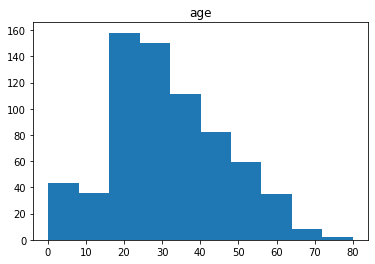

In [9]:
df.hist(
    column='age',
    grid=False
)
plt.show()

Come possiamo vedere, l'età ricorda una distribuzione di Rayleigh. Ci attendiamo lo stesso per un'altra dimensione che possiamo esplorare, ovvero quella delle tariffe pagate dai singoli passeggeri.

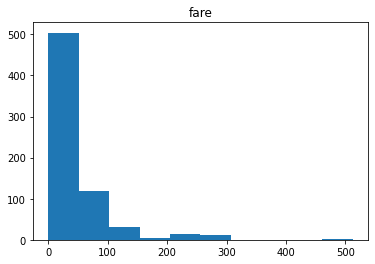

In [10]:
df.hist(
    column='fare',
    grid=False
)
plt.show()

Vediamo come si dispongono le due feature usando uno scatter plot.

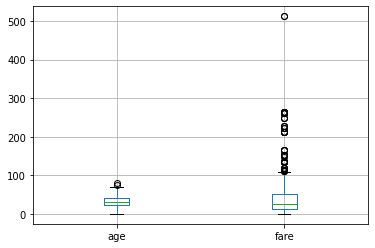

In [11]:
df.boxplot(['age', 'fare'])
plt.show()

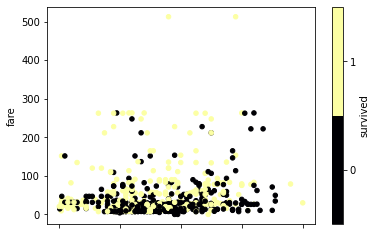

In [12]:
df.plot.scatter(x='age', y='fare', c='survived', cmap='inferno')
plt.show()

Notiamo come la variabilità dell'età è sufficiente, mentre quella del ticket è bassa. Potremmo quindi provare ad usare una tecnica di feature selection basata su `VarianceThreshold`.

In ultimo, valutiamo la matrice di correlazione. Usiamo l'indice di correlazione di Kendall, che risulta essere maggiormente robusto rispetto a quello di Pearson ed a quello di Spearman. Per approfondire, ecco un [eccellente punto di partenza](https://datascience.stackexchange.com/a/64261) su Stack Exchange.

In [13]:
df.corr(method='kendall')

,pclass,age,sibsp,parch,fare
pclass,1.000000,-0.295394,-0.464471,-0.488548,-0.490492
age,-0.295394,1.000000,-0.511169,-0.631767,0.129443
sibsp,-0.464471,-0.511169,1.000000,-0.322768,0.199986
parch,-0.488548,-0.631767,-0.322768,1.000000,0.194832
fare,-0.490492,0.129443,0.199986,0.194832,1.000000


E' facile vedere come i risultati ci conducano alla conclusione che non vi sono feature fortemente correlate od anticorrelate; la correlazione maggiore che è possibile riscontrare è infatti tra classe del passeggero e tariffa (ed è negativa, come prevedibile: ciò significa che passeggeri con classe numerica più alta, ovvero terza, hanno pagato meno rispetto a passeggeri con classe numerica più bassa, ovvero seconda e prima).

## Parte 3: pipeline di machine learning

Possiamo adesso passare a creare due pipeline per il machine learning. 

Useremo in tal senso due classificatori: il primo sarà basato su alberi decisionali, mentre il secondo sarà un *multi-layer perceptron*, modellato grazie alla classe [`MPLClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

Prima di continuare, però, isoliamo le label del database. Per farlo, usiamo la funzione [`pop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pop.html):

In [14]:
y = df.pop('survived')

Definiamo ora un `ColumnTransformer` che codifichi le feature in precedenza indicate come categorical:

In [15]:
ct = ColumnTransformer(
    [('sex_tr', OneHotEncoder(handle_unknown='ignore'), ['sex']),
     ('embarked_tr', OneHotEncoder(handle_unknown='ignore'), ['embarked']),
     ('boat_tr', OneHotEncoder(handle_unknown='ignore'), ['boat']),
     ('home.dest_tr', OneHotEncoder(handle_unknown='ignore'), ['home.dest'])],
    remainder='passthrough')

X = ct.fit_transform(df)

Possiamo ora definire le nostre due processing pipeline, una per ognuno dei possibili classificatori.

In [16]:
dt_pipeline = Pipeline([
    ('feat_sel', VarianceThreshold(.8 * 1 - .8)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

mlp_pipeline = Pipeline([
    ('feat_sel', VarianceThreshold(.8 * 1 - .8)),
    ('mlp', MLPClassifier(random_state=42))
])

Applichiamo la `GridSearchCV` su ognuna delle due pipeline. Dato che queste offrono un'interfaccia analoga a quella dei classici stimatori, potremo usare la stessa modalità vista in precedenza sui regressori; l'unica accortezza starà nello specificare a quale step della pipeline si riferiscono i parametri indicati nella griglia, usando una notazione:

```python
step_name__param_name
```

In [17]:
dt_params = {
    'dt__max_depth': list(range(1, 11)),
    'dt__criterion': ['gini', 'entropy'],
}

mlp_params = {
    'mlp__hidden_layer_sizes': [50, 100, 150, 200],
    'mlp__activation': ['logistic', 'tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__learning_rate': ['constant', 'adaptive'],
}

dt_search = GridSearchCV(dt_pipeline, dt_params)
dt_search = dt_search.fit(X, y)

mlp_search = GridSearchCV(mlp_pipeline, mlp_params)
mlp_search = mlp_search.fit(X, y)

Vediamo quali sono i migliori punteggi ottenuti da entrambe le pipeline.

In [18]:
print('Accuracy per la pipeline con albero decisionale: ~{}%'.format(
    round(dt_search.best_score_ * 100)))
print('Accuracy per la pipeline con MLP: ~{}%'.format(
    round(mlp_search.best_score_ * 100)))

Accuracy per la pipeline con albero decisionale: ~98%
Accuracy per la pipeline con MLP: ~96%


Ovviamente, potremo usare in inferenza la pipeline addestrata esattamente come uno stimatore mediante il metodo `predict`.

## Note finali

Scegliere tra un gran numero di stimatori può essere un'operazione abbastanza onerosa. Per questo, esiste un'intera branca del machine learning, chiamata *AutoML*, che si occupa di automatizzare la scelta, rendendo il processo trasparente all'utente. In tal senso, un tool per l'AutoML basato su Scikit Learn è [AutoSKLearn](https://github.com/automl/auto-sklearn). Questo è, al momento, disponibile soltanto per macchine non Windows; tuttavia, il consiglio è quello di darci un'occhiata, se possibile.